## Setup: Install dependencies and import libraries


In [ ]:
%pip install -q \
  transformers \
  peft \
  accelerate \
  datasets \
  rouge-score \
  huggingface_hub \
  matplotlib \
  textblob \
  optimum \
  auto-gptq \
  sentence-transformers \
  tqdm \
  torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from textblob import download_corpora

import os
import gc
import time
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore", category=UserWarning)

import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
from textblob import TextBlob

from datasets import load_dataset, Dataset
from huggingface_hub import login

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainerCallback,
)

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PromptTuningConfig,
)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data loading

Dyanmically load data from Google Drive if in Colab, else load from local directory

In [ ]:
def is_colab():
    
    try:
        import google.colab
        return True
    except ImportError:
        return False

def load_data():

    if is_colab():
        from google.colab import drive, userdata

        token = userdata.get("HUGGINGFACE_TOKEN")
        login(token=token)

        drive.mount('/content/drive', force_remount=True)

        os.makedirs("/content/local_data", exist_ok=True)
        !cp "/content/drive/MyDrive/code/data/train.json" /content/local_data/train.json
        !cp "/content/drive/MyDrive/code/data/val.json" /content/local_data/val.json
        !cp "/content/drive/MyDrive/code/data/test.json" /content/local_data/test.json

        data_path = "/content/local_data"

    else:
        data_path = "data"  

    train_df = pd.read_json(f"{data_path}/train.json", lines=True)
    val_df = pd.read_json(f"{data_path}/val.json", lines=True)
    test_df = pd.read_json(f"{data_path}/test.json", lines=True)

    train_data = Dataset.from_pandas(train_df)
    val_data = Dataset.from_pandas(val_df)
    test_data = Dataset.from_pandas(test_df)

    print(f"Loaded: {len(train_data)} train | {len(val_data)} val | {len(test_data)} test")

    return train_data, val_data, test_data

train_data, val_data, test_data = load_data()

Mounted at /content/drive
Loaded: 400 train | 50 val | 50 test


# Evaluation helper functions

In [ ]:
class LossTracker(TrainerCallback):
    def __init__(self):
        self.logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.logs.append(logs)

def plot_loss(logs, title):

    steps = [x.get("step", i * 5) for i, x in enumerate(logs) if "loss" in x]
    losses = [x["loss"] for x in logs if "loss" in x]
    plt.plot(steps, losses, label="Train Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid()
    plt.show()

def evaluate_model(model, name):

    model.config.use_cache = False

    total_bleu = 0
    total_rouge = {"rouge-1": 0, "rouge-2": 0, "rouge-l": 0}
    start = time.time()

    for ex in tqdm(test_data, desc=f"Evaluating {name}"):
        pred = generate_response(ex["input"], model, tokenizer)

        total_bleu += sentence_bleu([ex["output"].split()], pred.split())
        scores = scorer.score(ex["output"], pred)
        total_rouge["rouge-1"] += scores["rouge1"].fmeasure
        total_rouge["rouge-2"] += scores["rouge2"].fmeasure
        total_rouge["rouge-l"] += scores["rougeL"].fmeasure

    total_time = time.time() - start
    n = len(test_data)

    metrics = {
        "BLEU": total_bleu / n,
        "ROUGE-1": total_rouge["rouge-1"] / n,
        "ROUGE-2": total_rouge["rouge-2"] / n,
        "ROUGE-L": total_rouge["rouge-l"] / n,
        "Latency": total_time / n
    }

    print(f"\n--- {name} MODEL EVALUATION ---\n")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics

def print_trainable_params(model, label):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    pct = (trainable / total) * 100
    print(f"{label} - Trainable params: {trainable:,} / {total:,} ({pct:.4f}%)")

def score_priority(user_input):

    keywords = [
    "cancel", "refund", "charge", "billing", "dispute", "issue",
    "angry", "unacceptable", "lawsuit", "legal", "scam", "fraud",
    "complaint", "escalate", "speak to manager", "terrible", "disappointed"
    ]

    score = sum(word in user_input.lower() for word in keywords)
    if score >= 3:
        return "HIGH"
    elif score == 2:
        return "MEDIUM"
    else:
        return "LOW"

def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity < -0.3:
        return "NEGATIVE"
    elif polarity > 0.3:
        return "POSITIVE"
    else:
        return "NEUTRAL"

def generate_response(user_input, model, tokenizer):
    priority = score_priority(user_input)
    sentiment = analyze_sentiment(user_input)

    prompt = (
        f"[SYSTEM: This agent must reply in a calm, helpful tone.]\n"
        f"[PRIORITY: {priority}] [SENTIMENT: {sentiment}] "
        f"Customer message: {user_input}\nAgent response:"
    )

    model.config.use_cache = False
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
      outputs = model.generate(**inputs, max_new_tokens=50, use_cache=False)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Master evaulation function

In [6]:
def analyze_model(model, model_label, callback_logs, results_dict):

    plot_loss(callback_logs, f"{model_label} Training Loss")

    model.eval()
    model.to("cuda")
    metrics = evaluate_model(model, name=model_label)
    results_dict[model_label] = metrics

    print(f"\nInference Latency for {model_label}: {round(metrics['Latency'], 2)} seconds/sample")
    print_trainable_params(model, model_label)

    print(f"\n--- Sample Outputs for {model_label} ---")
    for i in range(3):
        ex = test_data[i]
        print(f"\nInput: {ex['input']}")
        print(f"Target: {ex['output']}")
        print(f"{model_label}: {generate_response(ex['input'], model, tokenizer)}")
        print("-" * 60)

    def categorize_input(text):
        if any(k in text.lower() for k in ["cancel", "angry", "bad", "refund", "issue"]):
            return "complaint"
        elif "?" in text:
            return "question"
        else:
            return "other"

    test_data_with_cat = test_data.map(lambda x: {"category": categorize_input(x["input"])})

    def evaluate_by_category(model, dataset):
        scores = defaultdict(lambda: {"bleu": [], "rouge-l": []})
        for ex in tqdm(dataset):
            pred = generate_response(ex["input"], model, tokenizer)
            scores[ex["category"]]["bleu"].append(
                sentence_bleu([ex["output"].split()], pred.split())
            )
            rouge_score = scorer.score(ex["output"], pred)["rougeL"].fmeasure
            scores[ex["category"]]["rouge-l"].append(rouge_score)

        print(f"\n{model_label} Evaluation by Category")
        for cat in scores:
            b = sum(scores[cat]["bleu"]) / len(scores[cat]["bleu"])
            r = sum(scores[cat]["rouge-l"]) / len(scores[cat]["rouge-l"])
            print(f"{cat}: BLEU={b:.4f}, ROUGE-L={r:.4f}")

    evaluate_by_category(model, test_data_with_cat)

    def get_worst_samples(metric="bleu", n=5):

        scored_samples = []
        for ex in tqdm(test_data):
            pred = generate_response(ex["input"], model, tokenizer)
            if metric == "bleu":
                score = sentence_bleu([ex["output"].split()], pred.split())
            elif metric == "rouge":
                score = scorer.score(ex["output"], pred)["rougeL"].fmeasure
            else:
                raise ValueError("Unsupported metric.")
            scored_samples.append((score, ex["input"], ex["output"], pred))

        return sorted(scored_samples, key=lambda x: x[0])[:n]

    def print_worst_cases(samples, metric):

        print(f"\n\n--- Worst {metric.upper()} Cases for {model_label} ---")

        for score, inp, target, pred in samples:

            print(f"Input: {inp}")
            print(f"Target: {target}")
            print(f"Prediction: {pred}")
            print(f"{metric.upper()} Score: {score:.4f}")
            print("-" * 60)

    print_worst_cases(get_worst_samples("bleu", n=4), "bleu")
    print_worst_cases(get_worst_samples("rouge", n=4), "rouge")

    print(f"\nDone analyzing {model_label}.\n")

# Training loop

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

  0%|          | 0/4 [00:00<?, ?it/s]



Training QLoRA-r8...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,3.749200
10,3.386800
15,3.252100
20,2.971300
25,2.746300
30,2.631900
35,2.726000
40,2.606900
45,2.630700
50,2.597000


Training Finished


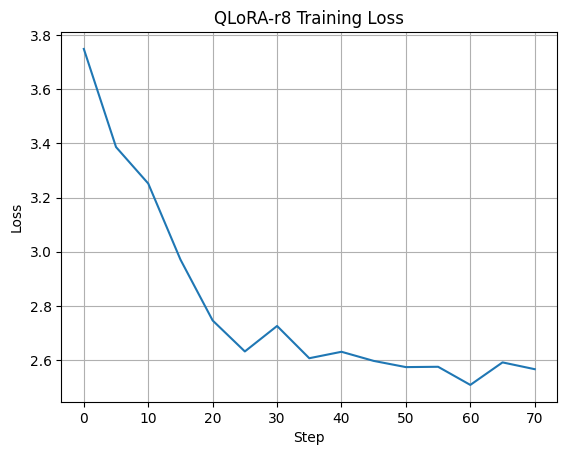


Evaluating QLoRA-r8: 100%|██████████| 50/50 [03:48<00:00,  4.56s/it]



--- QLoRA-r8 MODEL EVALUATION ---

BLEU: 0.0022
ROUGE-1: 0.1395
ROUGE-2: 0.0228
ROUGE-L: 0.0927
Latency: 4.5638

Inference Latency for QLoRA-r8: 4.56 seconds/sample
QLoRA-r8 - Trainable params: 1,126,400 / 1,101,174,784 (0.1023%)

--- Sample Outputs for QLoRA-r8 ---

Input: @693515 @693516 @TwitterSupport Im getting bullied.
Target: @693514 Thanks for letting us know. Please send us a message and we'll work on getting this resolved for you. https://t.co/eXwzpNxIh4
QLoRA-r8: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @693515 @693516 @TwitterSupport Im getting bullied.
Agent response: @693516 We're sorry to hear that. Please let us know if you need further assistance. 
[SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: L
------------------------------------------------------------

Input: @Uber_Support Do you even have a fuckin customer care number ? Now the cab that has arrived has to refuel! Seriousl

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]



QLoRA-r8 Evaluation by Category
other: BLEU=0.0036, ROUGE-L=0.0897
question: BLEU=0.0000, ROUGE-L=0.1060
complaint: BLEU=0.0000, ROUGE-L=0.0863



100%|██████████| 50/50 [03:52<00:00,  4.65s/it]




--- Worst BLEU Cases for QLoRA-r8 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: @790699 @790699 @790699 @790699 @790699 @790699 @790699 @
BLEU Score: 0.0000
------------------------------------------------------------
Input: @VirginTrains The connection, nothing would load...
Target: @324636 Sorry for that Lyd. ^PA
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @VirginTrains The connection, nothing would load...
Agent response: @1234567890 We're sorry to hear that. Please provide us with your full name and email address so we can assist you further. [SYSTEM: This agent must reply in a calm, helpful
BLEU Score: 0.0000
-----------------------------------------------------------


100%|██████████| 50/50 [03:55<00:00,  4.71s/it]




--- Worst ROUGE Cases for QLoRA-r8 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: @790699 @790699 @790699 @790699 @790699 @790699 @790699 @
ROUGE Score: 0.0000
------------------------------------------------------------
Input: @Delta Thx *ASK
Target: @159679 You are welcome. *AMS
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @Delta Thx *ASK
Agent response: @1234567890 [SYSTEM: This agent must reply in a calm, helpful tone.] [PRIORITY: LOW] [SENTIMENT: NEUTRAL]

[SY
ROUGE Score: 0.0000
------------------------------------------------------------
Input: @AmazonHelp ご丁寧にありがとうございます。海外在住なので、ショッピング系は送料が高く使えません。ビデオも制限かかって観たい物は観れませんでした。フォトは無料のgoo●lで充分。キンデル持ってません。海外発送料の割引があったら良いのですが…

 25%|██▌       | 1/4 [19:15<57:45, 1155.16s/it]



Training QLoRA-r4...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,3.791000
10,3.522900
15,3.457600
20,3.219300
25,2.991500
30,2.851500
35,2.892900
40,2.715100
45,2.706600
50,2.669200


Training Finished


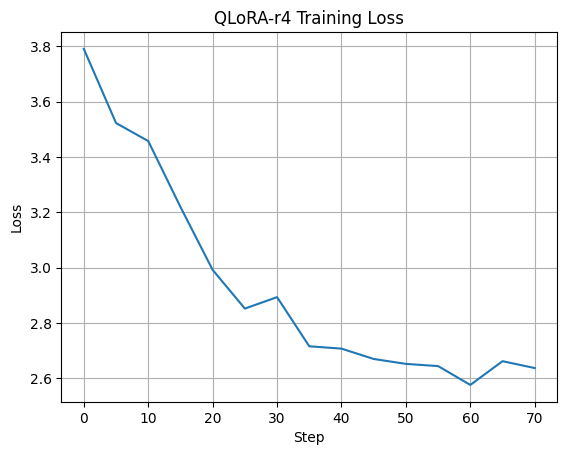


Evaluating QLoRA-r4: 100%|██████████| 50/50 [03:47<00:00,  4.56s/it]



--- QLoRA-r4 MODEL EVALUATION ---

BLEU: 0.0020
ROUGE-1: 0.1093
ROUGE-2: 0.0130
ROUGE-L: 0.0721
Latency: 4.5588

Inference Latency for QLoRA-r4: 4.56 seconds/sample
QLoRA-r4 - Trainable params: 563,200 / 1,100,611,584 (0.0512%)

--- Sample Outputs for QLoRA-r4 ---

Input: @693515 @693516 @TwitterSupport Im getting bullied.
Target: @693514 Thanks for letting us know. Please send us a message and we'll work on getting this resolved for you. https://t.co/eXwzpNxIh4
QLoRA-r4: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @693515 @693516 @TwitterSupport Im getting bullied.
Agent response: @693516 @693516 @123456789 @123456789 @123456789 @12345
------------------------------------------------------------

Input: @Uber_Support Do you even have a fuckin customer care number ? Now the cab that has arrived has to refuel! Seriously ??
Target: @426282 Here to help! Send us a note via https://t.co/e8HVorX5rh so our team can connect.

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


100%|██████████| 50/50 [03:48<00:00,  4.56s/it]



QLoRA-r4 Evaluation by Category
other: BLEU=0.0019, ROUGE-L=0.0638
question: BLEU=0.0040, ROUGE-L=0.0884
complaint: BLEU=0.0000, ROUGE-L=0.0820



100%|██████████| 50/50 [03:48<00:00,  4.56s/it]




--- Worst BLEU Cases for QLoRA-r4 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: @790699 😐
[SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: HIGH] [SENTIMENT: HAPPY] Customer
BLEU Score: 0.0000
------------------------------------------------------------
Input: @VirginTrains The connection, nothing would load...
Target: @324636 Sorry for that Lyd. ^PA
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @VirginTrains The connection, nothing would load...
Agent response: @123456789 We're sorry to hear that. Please let us know if you're still experiencing issues. [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRI
BLEU Score: 0.0000
------------------------


100%|██████████| 50/50 [03:47<00:00,  4.56s/it]




--- Worst ROUGE Cases for QLoRA-r4 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: @790699 😐
[SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: HIGH] [SENTIMENT: HAPPY] Customer
ROUGE Score: 0.0000
------------------------------------------------------------
Input: @AmazonHelp Highly doubtful
Target: @543355 May I ask if you have safe place preferences applied to your Amazon account? ^KI
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEGATIVE] Customer message: @AmazonHelp Highly doubtful
Agent response: @1234567890
[SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: HIGH] [SENTIMENT: NEGATIVE] Customer
ROUGE Score: 0.0000
-------------------------------------------------

 50%|█████     | 2/4 [38:09<38:05, 1142.65s/it]



Training Prompt-20...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,3.900300
10,3.503900
15,3.440600
20,3.291900
25,3.136000
30,3.076500
35,3.176600
40,3.026500
45,3.009800
50,2.975800


Training Finished


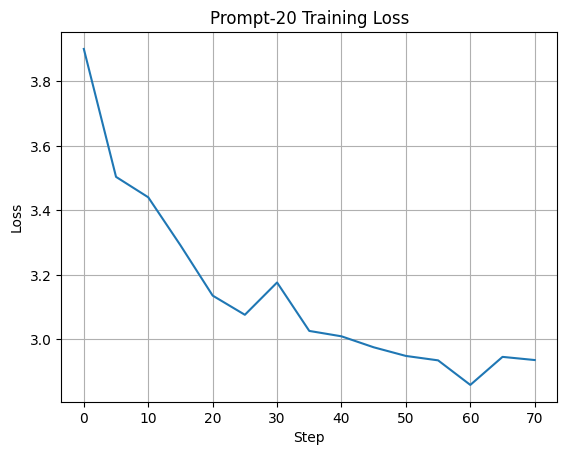


Evaluating Prompt-20: 100%|██████████| 50/50 [04:19<00:00,  5.18s/it]



--- Prompt-20 MODEL EVALUATION ---

BLEU: 0.0010
ROUGE-1: 0.1255
ROUGE-2: 0.0170
ROUGE-L: 0.0861
Latency: 5.1830

Inference Latency for Prompt-20: 5.18 seconds/sample
Prompt-20 - Trainable params: 40,960 / 1,100,089,344 (0.0037%)

--- Sample Outputs for Prompt-20 ---

Input: @693515 @693516 @TwitterSupport Im getting bullied.
Target: @693514 Thanks for letting us know. Please send us a message and we'll work on getting this resolved for you. https://t.co/eXwzpNxIh4
Prompt-20: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @693515 @693516 @TwitterSupport Im getting bullied.
Agent response: @693515 @693516 @TwitterSupport We're sorry to hear that you're experiencing this. Can you please provide us with your account information so we can investigate further?
[SY
------------------------------------------------------------

Input: @Uber_Support Do you even have a fuckin customer care number ? Now the cab that has arrived has

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


100%|██████████| 50/50 [04:19<00:00,  5.19s/it]



Prompt-20 Evaluation by Category
other: BLEU=0.0000, ROUGE-L=0.0837
question: BLEU=0.0045, ROUGE-L=0.0906
complaint: BLEU=0.0000, ROUGE-L=0.0891



100%|██████████| 50/50 [04:20<00:00,  5.20s/it]




--- Worst BLEU Cases for Prompt-20 ---
Input: @Uber_Support I have contacted twitter but no response has been received @116276 help??
Target: @550912 Happy to help, Mahesh. Please DM us the email address of the account holder and we'll follow up.
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @Uber_Support I have contacted twitter but no response has been received @116276 help??
Agent response: Hi @[SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: HIGH] [SENTIMENT: HIGH] Customer message: @Uber_Support I have contacted
BLEU Score: 0.0000
------------------------------------------------------------
Input: @AmazonHelp Computer says no
Target: @453687 Thanks for the update. Please call us by selecting Contact Us via the link ^GR provided. Keep us posted on the outcome. ^CO
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message


100%|██████████| 50/50 [04:19<00:00,  5.19s/it]




--- Worst ROUGE Cases for Prompt-20 ---
Input: @AmazonHelp Computer says no
Target: @453687 Thanks for the update. Please call us by selecting Contact Us via the link ^GR provided. Keep us posted on the outcome. ^CO
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @AmazonHelp Computer says no
Agent response: @AmazonHelp Computer says no
[SYSTEM: This agent must reply in a calm, helpful tone.]
[SYSTEM: This agent must reply in a calm, helpful tone.]
[SYSTEM: This agent
ROUGE Score: 0.0000
------------------------------------------------------------
Input: @Delta Thx *ASK
Target: @159679 You are welcome. *AMS
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @Delta Thx *ASK
Agent response: @Delta Thx *ASK
[SYSTEM: This agent must reply in a calm, helpful tone.]
[SYSTEM: This agent must reply in a calm, helpful tone.]
[SYSTEM: This agent mu

 75%|███████▌  | 3/4 [59:13<19:58, 1198.18s/it]



Training Prompt-10...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,3.832400
10,3.452600
15,3.415000
20,3.277200
25,3.137000
30,3.100000
35,3.226300
40,3.107600
45,3.120800
50,3.088000


Training Finished


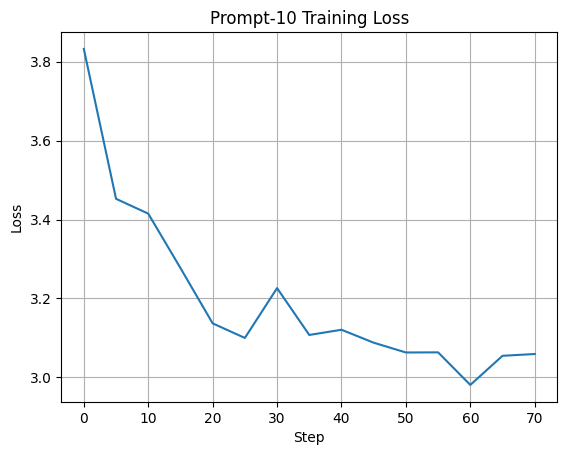


Evaluating Prompt-10: 100%|██████████| 50/50 [04:03<00:00,  4.87s/it]



--- Prompt-10 MODEL EVALUATION ---

BLEU: 0.0000
ROUGE-1: 0.1404
ROUGE-2: 0.0184
ROUGE-L: 0.0933
Latency: 4.8724

Inference Latency for Prompt-10: 4.87 seconds/sample
Prompt-10 - Trainable params: 20,480 / 1,100,068,864 (0.0019%)

--- Sample Outputs for Prompt-10 ---

Input: @693515 @693516 @TwitterSupport Im getting bullied.
Target: @693514 Thanks for letting us know. Please send us a message and we'll work on getting this resolved for you. https://t.co/eXwzpNxIh4
Prompt-10: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @693515 @693516 @TwitterSupport Im getting bullied.
Agent response: Hi @693515, we understand how frustrating it can be when you're being bullied online. We're sorry to hear that you're experiencing this. Please let us know if there's anything
------------------------------------------------------------

Input: @Uber_Support Do you even have a fuckin customer care number ? Now the cab that has arrived h

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


100%|██████████| 50/50 [04:04<00:00,  4.88s/it]



Prompt-10 Evaluation by Category
other: BLEU=0.0000, ROUGE-L=0.0889
question: BLEU=0.0000, ROUGE-L=0.1047
complaint: BLEU=0.0000, ROUGE-L=0.0947



100%|██████████| 50/50 [04:02<00:00,  4.85s/it]




--- Worst BLEU Cases for Prompt-10 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: Hi Koby, I'm sorry to hear that you're having trouble with your service. Please provide me with your account number so I can look into this for you. Agent: @790699 @CenturyLinkHelp
BLEU Score: 0.0000
------------------------------------------------------------
Input: @Delta Thx *ASK
Target: @159679 You are welcome. *AMS
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @Delta Thx *ASK
Agent response: Hi @Delta Thx, I'm sorry to hear that you're experiencing a problem with your flight. Please provide me with your reservation number so I can assist you better. Thank you.

[SYSTEM: This
BLEU Score: 0.0


100%|██████████| 4/4 [1:19:08<00:00, 1187.16s/it]



--- Worst ROUGE Cases for Prompt-10 ---
Input: @790699 @CenturyLinkHelp Koby 😐
Target: @790698 Kevin would be my name :) Reach out anytime. -Kevin
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @790699 @CenturyLinkHelp Koby 😐
Agent response: Hi Koby, I'm sorry to hear that you're having trouble with your service. Please provide me with your account number so I can look into this for you. Agent: @790699 @CenturyLinkHelp
ROUGE Score: 0.0000
------------------------------------------------------------
Input: @AmazonHelp ご丁寧にありがとうございます。海外在住なので、ショッピング系は送料が高く使えません。ビデオも制限かかって観たい物は観れませんでした。フォトは無料のgoo●lで充分。キンデル持ってません。海外発送料の割引があったら良いのですが…
Target: @736189 海外配送についてご意見をお寄せいただき、ありがとうございます。ご指摘いただいた点は担当部署に伝えさせていただき、今後もサービスや機能の改善に努めて参ります。 YM
Prediction: [SYSTEM: This agent must reply in a calm, helpful tone.]
[PRIORITY: LOW] [SENTIMENT: NEUTRAL] Customer message: @AmazonHelp ご丁寧にありがとうございます。海外在住なので、ショッピング系は送料が高く使えません。ビデオも制限かか

In [ ]:
def preprocess(example):
    prompt = f"Customer message: {example['input']}\nAgent response: {example['output']}"
    return tokenizer(prompt, truncation=True, padding="max_length", max_length=512)

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

training_args = TrainingArguments(
    output_dir="./models/qlora/",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    eval_strategy="no",
    eval_steps=100,
    logging_steps=5,
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,
    report_to="none",
    disable_tqdm=False
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
results = {}

model_configs = [
    {
        "label": "QLoRA-r8",
        "get_model": lambda: get_peft_model(
            prepare_model_for_kbit_training(AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")),
            LoraConfig(
                r=8,
                lora_alpha=32,
                target_modules=["q_proj", "v_proj"],
                lora_dropout=0.05,
                bias="none",
                task_type="CAUSAL_LM"
            )
        )
    },
    {
        "label": "QLoRA-r4",
        "get_model": lambda: get_peft_model(
            prepare_model_for_kbit_training(AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")),
            LoraConfig(
                r=4,
                lora_alpha=16,
                target_modules=["q_proj", "v_proj"],
                lora_dropout=0.05,
                bias="none",
                task_type="CAUSAL_LM"
            )
        )
    },
    {
        "label": "Prompt-20",
        "get_model": lambda: get_peft_model(
            AutoModelForCausalLM.from_pretrained(model_name, device_map="auto"),
            PromptTuningConfig(
                task_type="CAUSAL_LM",
                prompt_tuning_init="TEXT",
                prompt_tuning_init_text="You are a helpful customer support assistant.",
                num_virtual_tokens=20,
                tokenizer_name_or_path=model_name
            )
        )
    },
    {
        "label": "Prompt-10",
        "get_model": lambda: get_peft_model(
            AutoModelForCausalLM.from_pretrained(model_name, device_map="auto"),
            PromptTuningConfig(
                task_type="CAUSAL_LM",
                prompt_tuning_init="TEXT",
                prompt_tuning_init_text="You are a helpful customer support assistant.",
                num_virtual_tokens=10,
                tokenizer_name_or_path=model_name
            )
        )
    }
]

for config in tqdm(model_configs):

    print(f"\n\nTraining {config['label']}...")
    callback = LossTracker()
    model = config["get_model"]()

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        data_collator=data_collator,
        callbacks=[callback]
    )

    trainer.train()
    print("Training Finished")
    analyze_model(model, config["label"], callback.logs, results)

    del trainer
    del model
    gc.collect()
    torch.cuda.empty_cache()


# Metric aggregation

                   BLEU   ROUGE-1   ROUGE-2   ROUGE-L
QLoRA-r8   2.214078e-03  0.139544  0.022822  0.092735
QLoRA-r4   2.022630e-03  0.109348  0.013047  0.072147
Prompt-20  9.856825e-04  0.125511  0.016967  0.086099
Prompt-10  6.376988e-80  0.140400  0.018396  0.093327


<Figure size 1000x600 with 0 Axes>

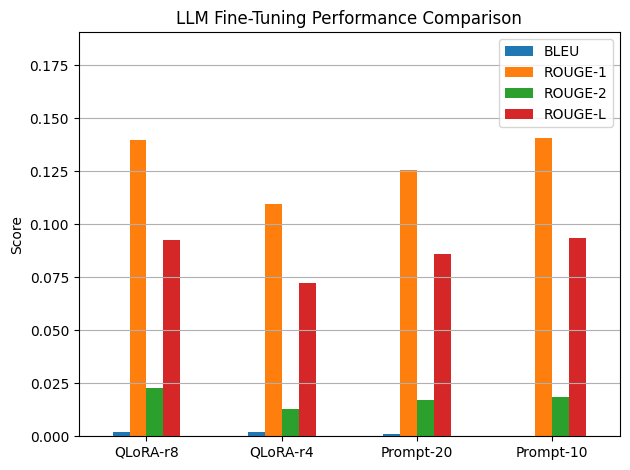

Inference Latency per Sample (seconds):
QLoRA-r8: 4.56s
QLoRA-r4: 4.56s
Prompt-20: 5.18s
Prompt-10: 4.87s


In [ ]:
df = pd.DataFrame(results).T[["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]]
print(df)
max_score = df.max().max()
plt.figure(figsize=(10, 6))
df.plot(kind="bar")
plt.ylim(0, max_score + 0.05) 
plt.title("LLM Fine-Tuning Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



latencies = {name: round(m["Latency"], 2) for name, m in results.items()}
print("Inference Latency per Sample (seconds):")
for k, v in latencies.items():
    print(f"{k}: {v}s")

